## 여러 machine Learning model 사용

### LightGBM

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [8]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

In [9]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [10]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc

from sklearn.utils import shuffle

results_summary = []

def method_evaluation(model, data_x, data_y, X_test, y_test, method):
    print(f"Preprocessing method : {method}")

    if method == 'Base':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )

        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'Undersampling':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, stratify=data_y)
        undersampler = RandomUnderSampler()
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)
        X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
        y_train = data_under[['loan_status']]  # Target (타겟 변수)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'SMOTE':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, stratify=data_y)

        smote = SMOTE()

        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)
        X_train = augmentation_data.drop(columns='loan_status')
        y_train = augmentation_data[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'table-gan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/return_feature/return_feature_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1
        
        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)

        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'Smotified-gan':
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/oversampled/oversampled_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    

    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)

    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    au_prc = auc(recall, precision)

    results_summary.append({
    'Method': method,
    'Recall_0': recall_0,
    'Precision_0': precision_0,
    'F1_0': f1_0,
    'Recall_1': recall_1,
    'Precision_1': precision_1,
    'F1_1': f1_1,
    'AU_PRC': au_prc,
    'y_prob': y_prob,
    'y_test': y_test.squeeze()  
    })

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from tqdm import tqdm

Methods = ['Base', 'Undersampling', 'SMOTE', 'table-gan','Smotified-gan']
n_runs = 250

all_results = []

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification['loan_status']

for method in Methods:
    print(f"\n===== {method} 시작 =====")
    
    method_results = []

    for run in tqdm(range(n_runs), desc=f'{method} Repeats'):
        data_x = data_classification.drop(columns='loan_status')
        data_y = data_classification['loan_status']

        params = {
            'objective': 'binary',
            'num_leaves': 31,
            'n_estimators': 500,
            'class_weight': None,
        }

        lgbm_model = LGBMClassifier(**params)

        method_evaluation(lgbm_model, data_x, data_y, X_test, y_test, method)

        last_result = results_summary[-1]  # 방금 추가된 결과만 가져옴
        method_results.append(last_result)

    all_results.append((method, method_results))


===== Base 시작 =====


Base Repeats:   0%|          | 0/250 [00:00<?, ?it/s]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   0%|          | 1/250 [00:08<33:13,  8.00s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   1%|          | 2/250 [00:16<34:34,  8.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   1%|          | 3/250 [00:26<36:20,  8.83s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   2%|▏         | 4/250 [00:35<36:44,  8.96s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   2%|▏         | 5/250 [00:44<36:54,  9.04s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   2%|▏         | 6/250 [00:53<37:30,  9.23s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   3%|▎         | 7/250 [01:03<37:32,  9.27s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   3%|▎         | 8/250 [01:12<37:28,  9.29s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   4%|▎         | 9/250 [01:21<37:22,  9.31s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   4%|▍         | 10/250 [01:31<37:14,  9.31s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   4%|▍         | 11/250 [01:40<37:04,  9.31s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   5%|▍         | 12/250 [01:50<37:04,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   5%|▌         | 13/250 [01:59<37:06,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   6%|▌         | 14/250 [02:08<36:59,  9.40s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   6%|▌         | 15/250 [02:18<36:32,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   6%|▋         | 16/250 [02:27<36:36,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   7%|▋         | 17/250 [02:36<36:16,  9.34s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   7%|▋         | 18/250 [02:46<36:24,  9.42s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   8%|▊         | 19/250 [02:55<36:20,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   8%|▊         | 20/250 [03:05<36:00,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   8%|▊         | 21/250 [03:14<35:38,  9.34s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   9%|▉         | 22/250 [03:23<35:33,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:   9%|▉         | 23/250 [03:33<35:28,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  10%|▉         | 24/250 [03:42<35:20,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  10%|█         | 25/250 [03:51<35:06,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  10%|█         | 26/250 [04:01<35:03,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  11%|█         | 27/250 [04:11<35:15,  9.49s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  11%|█         | 28/250 [04:20<35:11,  9.51s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  12%|█▏        | 29/250 [04:29<34:47,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  12%|█▏        | 30/250 [04:39<34:26,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2977
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  12%|█▏        | 31/250 [04:48<34:27,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  13%|█▎        | 32/250 [04:58<34:11,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  13%|█▎        | 33/250 [05:07<34:08,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  14%|█▎        | 34/250 [05:17<34:06,  9.48s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  14%|█▍        | 35/250 [05:26<33:51,  9.45s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  14%|█▍        | 36/250 [05:36<33:42,  9.45s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  15%|█▍        | 37/250 [05:45<33:35,  9.46s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  15%|█▌        | 38/250 [05:55<33:43,  9.55s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  16%|█▌        | 39/250 [06:04<33:22,  9.49s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  16%|█▌        | 40/250 [06:14<33:14,  9.50s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  16%|█▋        | 41/250 [06:23<32:52,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  17%|█▋        | 42/250 [06:32<32:44,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  17%|█▋        | 43/250 [06:42<32:26,  9.40s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  18%|█▊        | 44/250 [06:51<32:02,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  18%|█▊        | 45/250 [07:00<31:51,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  18%|█▊        | 46/250 [07:10<31:41,  9.32s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  19%|█▉        | 47/250 [07:19<31:38,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  19%|█▉        | 48/250 [07:28<31:39,  9.40s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  20%|█▉        | 49/250 [07:38<31:31,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  20%|██        | 50/250 [07:47<31:26,  9.43s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  20%|██        | 51/250 [07:57<31:06,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  21%|██        | 52/250 [08:06<30:44,  9.32s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  21%|██        | 53/250 [08:15<30:28,  9.28s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  22%|██▏       | 54/250 [08:24<30:27,  9.32s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  22%|██▏       | 55/250 [08:34<30:05,  9.26s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  22%|██▏       | 56/250 [08:43<30:11,  9.34s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  23%|██▎       | 57/250 [08:52<30:04,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  23%|██▎       | 58/250 [09:02<30:03,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  24%|██▎       | 59/250 [09:11<29:55,  9.40s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  24%|██▍       | 60/250 [09:21<29:47,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  24%|██▍       | 61/250 [09:30<29:31,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  25%|██▍       | 62/250 [09:39<29:20,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  25%|██▌       | 63/250 [09:49<29:08,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2977
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  26%|██▌       | 64/250 [09:58<28:59,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  26%|██▌       | 65/250 [10:07<28:48,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  26%|██▋       | 66/250 [10:17<28:34,  9.32s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  27%|██▋       | 67/250 [10:26<28:28,  9.34s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  27%|██▋       | 68/250 [10:36<28:32,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  28%|██▊       | 69/250 [10:45<28:15,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  28%|██▊       | 70/250 [10:54<27:56,  9.31s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  28%|██▊       | 71/250 [11:03<27:44,  9.30s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  29%|██▉       | 72/250 [11:13<27:28,  9.26s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  29%|██▉       | 73/250 [11:22<27:14,  9.23s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  30%|██▉       | 74/250 [11:31<27:20,  9.32s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  30%|███       | 75/250 [11:41<27:12,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  30%|███       | 76/250 [11:50<27:03,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  31%|███       | 77/250 [12:00<27:11,  9.43s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  31%|███       | 78/250 [12:09<26:54,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  32%|███▏      | 79/250 [12:18<26:39,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  32%|███▏      | 80/250 [12:28<26:36,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  32%|███▏      | 81/250 [12:37<26:34,  9.43s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  33%|███▎      | 82/250 [12:46<26:17,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  33%|███▎      | 83/250 [12:56<26:07,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  34%|███▎      | 84/250 [13:05<26:02,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  34%|███▍      | 85/250 [13:15<25:44,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2977
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  34%|███▍      | 86/250 [13:24<25:44,  9.42s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  35%|███▍      | 87/250 [13:34<25:39,  9.45s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  35%|███▌      | 88/250 [13:43<25:51,  9.58s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  36%|███▌      | 89/250 [13:53<25:32,  9.52s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  36%|███▌      | 90/250 [14:02<25:12,  9.45s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  36%|███▋      | 91/250 [14:12<24:58,  9.43s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  37%|███▋      | 92/250 [14:21<24:40,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  37%|███▋      | 93/250 [14:30<24:23,  9.32s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  38%|███▊      | 94/250 [14:39<24:23,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  38%|███▊      | 95/250 [14:49<24:34,  9.52s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  38%|███▊      | 96/250 [14:59<24:15,  9.45s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  39%|███▉      | 97/250 [15:08<24:06,  9.45s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  39%|███▉      | 98/250 [15:18<24:02,  9.49s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  40%|███▉      | 99/250 [15:27<23:45,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  40%|████      | 100/250 [15:36<23:40,  9.47s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  40%|████      | 101/250 [15:46<23:24,  9.43s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  41%|████      | 102/250 [15:55<23:16,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  41%|████      | 103/250 [16:05<23:05,  9.43s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  42%|████▏     | 104/250 [16:14<22:57,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  42%|████▏     | 105/250 [16:23<22:39,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  42%|████▏     | 106/250 [16:33<22:44,  9.47s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  43%|████▎     | 107/250 [16:43<22:32,  9.46s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  43%|████▎     | 108/250 [16:52<22:16,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  44%|████▎     | 109/250 [17:01<21:59,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2977
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  44%|████▍     | 110/250 [17:10<21:29,  9.21s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  44%|████▍     | 111/250 [17:19<21:17,  9.19s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  45%|████▍     | 112/250 [17:28<21:03,  9.16s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  45%|████▌     | 113/250 [17:37<21:02,  9.22s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  46%|████▌     | 114/250 [17:47<21:01,  9.27s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  46%|████▌     | 115/250 [17:56<21:02,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  46%|████▋     | 116/250 [18:06<21:01,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  47%|████▋     | 117/250 [18:15<20:50,  9.40s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  47%|████▋     | 118/250 [18:25<20:42,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  48%|████▊     | 119/250 [18:34<20:32,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  48%|████▊     | 120/250 [18:44<20:21,  9.40s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  48%|████▊     | 121/250 [18:53<20:17,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  49%|████▉     | 122/250 [19:03<20:13,  9.48s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  49%|████▉     | 123/250 [19:12<20:03,  9.48s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  50%|████▉     | 124/250 [19:21<19:47,  9.42s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  50%|█████     | 125/250 [19:31<19:37,  9.42s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  50%|█████     | 126/250 [19:40<19:28,  9.42s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  51%|█████     | 127/250 [19:50<19:12,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  51%|█████     | 128/250 [19:59<19:05,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  52%|█████▏    | 129/250 [20:08<18:54,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  52%|█████▏    | 130/250 [20:18<18:47,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  52%|█████▏    | 131/250 [20:27<18:36,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  53%|█████▎    | 132/250 [20:37<18:28,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  53%|█████▎    | 133/250 [20:46<18:15,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  54%|█████▎    | 134/250 [20:55<18:05,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  54%|█████▍    | 135/250 [21:04<17:55,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  54%|█████▍    | 136/250 [21:14<17:43,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  55%|█████▍    | 137/250 [21:23<17:36,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  55%|█████▌    | 138/250 [21:32<17:21,  9.30s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  56%|█████▌    | 139/250 [21:42<17:08,  9.27s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  56%|█████▌    | 140/250 [21:51<16:53,  9.22s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  56%|█████▋    | 141/250 [22:00<16:53,  9.30s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  57%|█████▋    | 142/250 [22:10<16:49,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  57%|█████▋    | 143/250 [22:19<16:40,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  58%|█████▊    | 144/250 [22:28<16:34,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  58%|█████▊    | 145/250 [22:38<16:39,  9.52s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  58%|█████▊    | 146/250 [22:47<16:15,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  59%|█████▉    | 147/250 [22:57<16:03,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  59%|█████▉    | 148/250 [23:06<15:53,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  60%|█████▉    | 149/250 [23:15<15:47,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  60%|██████    | 150/250 [23:25<15:36,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  60%|██████    | 151/250 [23:34<15:19,  9.29s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  61%|██████    | 152/250 [23:43<15:13,  9.32s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  61%|██████    | 153/250 [23:53<15:12,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  62%|██████▏   | 154/250 [24:02<15:07,  9.45s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  62%|██████▏   | 155/250 [24:12<14:56,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  62%|██████▏   | 156/250 [24:21<14:39,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  63%|██████▎   | 157/250 [24:30<14:31,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  63%|██████▎   | 158/250 [24:40<14:24,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  64%|██████▎   | 159/250 [24:49<14:14,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  64%|██████▍   | 160/250 [24:59<14:04,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  64%|██████▍   | 161/250 [25:08<13:59,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  65%|██████▍   | 162/250 [25:18<13:54,  9.48s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  65%|██████▌   | 163/250 [25:27<13:46,  9.50s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  66%|██████▌   | 164/250 [25:37<13:33,  9.45s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  66%|██████▌   | 165/250 [25:46<13:18,  9.40s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  66%|██████▋   | 166/250 [25:55<13:11,  9.42s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  67%|██████▋   | 167/250 [26:05<13:00,  9.40s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  67%|██████▋   | 168/250 [26:14<12:57,  9.48s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  68%|██████▊   | 169/250 [26:24<12:46,  9.47s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  68%|██████▊   | 170/250 [26:33<12:28,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  68%|██████▊   | 171/250 [26:42<12:18,  9.34s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  69%|██████▉   | 172/250 [26:52<12:08,  9.34s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  69%|██████▉   | 173/250 [27:01<11:57,  9.32s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  70%|██████▉   | 174/250 [27:10<11:49,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  70%|███████   | 175/250 [27:20<11:43,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  70%|███████   | 176/250 [27:29<11:37,  9.43s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  71%|███████   | 177/250 [27:38<11:22,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  71%|███████   | 178/250 [27:48<11:16,  9.40s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  72%|███████▏  | 179/250 [27:58<11:13,  9.48s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  72%|███████▏  | 180/250 [28:07<11:03,  9.48s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  72%|███████▏  | 181/250 [28:17<10:53,  9.48s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  73%|███████▎  | 182/250 [28:26<10:42,  9.44s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  73%|███████▎  | 183/250 [28:35<10:31,  9.43s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  74%|███████▎  | 184/250 [28:45<10:22,  9.43s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  74%|███████▍  | 185/250 [28:54<10:07,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  74%|███████▍  | 186/250 [29:03<09:56,  9.32s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  75%|███████▍  | 187/250 [29:12<09:47,  9.32s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  75%|███████▌  | 188/250 [29:22<09:41,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  76%|███████▌  | 189/250 [29:31<09:31,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  76%|███████▌  | 190/250 [29:41<09:22,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  76%|███████▋  | 191/250 [29:50<09:13,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  77%|███████▋  | 192/250 [30:00<09:05,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  77%|███████▋  | 193/250 [30:09<09:01,  9.50s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  78%|███████▊  | 194/250 [30:19<08:54,  9.55s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  78%|███████▊  | 195/250 [30:28<08:41,  9.48s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  78%|███████▊  | 196/250 [30:38<08:32,  9.48s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  79%|███████▉  | 197/250 [30:47<08:19,  9.42s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  79%|███████▉  | 198/250 [30:56<08:06,  9.36s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  80%|███████▉  | 199/250 [31:05<07:56,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  80%|████████  | 200/250 [31:15<07:45,  9.31s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  80%|████████  | 201/250 [31:24<07:39,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  81%|████████  | 202/250 [31:34<07:28,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  81%|████████  | 203/250 [31:43<07:18,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  82%|████████▏ | 204/250 [31:52<07:05,  9.25s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  82%|████████▏ | 205/250 [32:01<06:55,  9.24s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  82%|████████▏ | 206/250 [32:10<06:47,  9.27s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  83%|████████▎ | 207/250 [32:20<06:44,  9.40s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  83%|████████▎ | 208/250 [32:30<06:37,  9.46s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  84%|████████▎ | 209/250 [32:39<06:29,  9.51s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  84%|████████▍ | 210/250 [32:49<06:15,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  84%|████████▍ | 211/250 [32:58<06:05,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  85%|████████▍ | 212/250 [33:07<05:54,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  85%|████████▌ | 213/250 [33:16<05:43,  9.29s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  86%|████████▌ | 214/250 [33:25<05:33,  9.26s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2977
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  86%|████████▌ | 215/250 [33:35<05:22,  9.23s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  86%|████████▋ | 216/250 [33:44<05:14,  9.26s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  87%|████████▋ | 217/250 [33:53<05:04,  9.22s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  87%|████████▋ | 218/250 [34:02<04:56,  9.25s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  88%|████████▊ | 219/250 [34:12<04:47,  9.27s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  88%|████████▊ | 220/250 [34:21<04:40,  9.35s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  88%|████████▊ | 221/250 [34:30<04:29,  9.30s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2977
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  89%|████████▉ | 222/250 [34:39<04:17,  9.21s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  89%|████████▉ | 223/250 [34:48<04:06,  9.13s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  90%|████████▉ | 224/250 [34:58<03:59,  9.22s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  90%|█████████ | 225/250 [35:07<03:49,  9.20s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  90%|█████████ | 226/250 [35:16<03:42,  9.25s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  91%|█████████ | 227/250 [35:26<03:33,  9.30s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  91%|█████████ | 228/250 [35:35<03:24,  9.28s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  92%|█████████▏| 229/250 [35:44<03:15,  9.31s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  92%|█████████▏| 230/250 [35:54<03:05,  9.26s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  92%|█████████▏| 231/250 [36:03<02:55,  9.23s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  93%|█████████▎| 232/250 [36:12<02:46,  9.24s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  93%|█████████▎| 233/250 [36:21<02:38,  9.31s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  94%|█████████▎| 234/250 [36:31<02:29,  9.34s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  94%|█████████▍| 235/250 [36:40<02:21,  9.41s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  94%|█████████▍| 236/250 [36:50<02:11,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  95%|█████████▍| 237/250 [36:59<02:01,  9.37s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  95%|█████████▌| 238/250 [37:09<01:52,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  96%|█████████▌| 239/250 [37:18<01:43,  9.39s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  96%|█████████▌| 240/250 [37:27<01:33,  9.38s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  96%|█████████▋| 241/250 [37:36<01:23,  9.29s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  97%|█████████▋| 242/250 [37:45<01:13,  9.24s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  97%|█████████▋| 243/250 [37:55<01:04,  9.27s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  98%|█████████▊| 244/250 [38:04<00:55,  9.22s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  98%|█████████▊| 245/250 [38:13<00:46,  9.33s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  98%|█████████▊| 246/250 [38:23<00:37,  9.34s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  99%|█████████▉| 247/250 [38:32<00:27,  9.27s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats:  99%|█████████▉| 248/250 [38:41<00:18,  9.26s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats: 100%|█████████▉| 249/250 [38:50<00:09,  9.27s/it]

Preprocessing method : Base
[LightGBM] [Info] Number of positive: 174231, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2976
[LightGBM] [Info] Number of data points in the train set: 893166, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.195071 -> initscore=-1.417389
[LightGBM] [Info] Start training from score -1.417389


Base Repeats: 100%|██████████| 250/250 [39:00<00:00,  9.36s/it]



===== Undersampling 시작 =====


Undersampling Repeats:   0%|          | 0/250 [00:00<?, ?it/s]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   0%|          | 1/250 [00:05<24:05,  5.80s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   1%|          | 2/250 [00:11<24:13,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   1%|          | 3/250 [00:17<24:16,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   2%|▏         | 4/250 [00:23<24:21,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   2%|▏         | 5/250 [00:29<24:12,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   2%|▏         | 6/250 [00:35<24:02,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   3%|▎         | 7/250 [00:41<23:37,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   3%|▎         | 8/250 [00:47<23:37,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   4%|▎         | 9/250 [00:52<23:29,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   4%|▍         | 10/250 [00:58<23:19,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   4%|▍         | 11/250 [01:04<23:13,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   5%|▍         | 12/250 [01:10<23:13,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   5%|▌         | 13/250 [01:16<23:09,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   6%|▌         | 14/250 [01:22<23:19,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   6%|▌         | 15/250 [01:28<23:07,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   6%|▋         | 16/250 [01:34<22:58,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   7%|▋         | 17/250 [01:40<22:58,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   7%|▋         | 18/250 [01:45<22:42,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   8%|▊         | 19/250 [01:51<22:35,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   8%|▊         | 20/250 [01:57<22:14,  5.80s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   8%|▊         | 21/250 [02:03<22:09,  5.81s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   9%|▉         | 22/250 [02:08<21:52,  5.76s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:   9%|▉         | 23/250 [02:14<21:39,  5.72s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  10%|▉         | 24/250 [02:20<21:40,  5.75s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  10%|█         | 25/250 [02:26<21:42,  5.79s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  10%|█         | 26/250 [02:31<21:30,  5.76s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  11%|█         | 27/250 [02:37<21:31,  5.79s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  11%|█         | 28/250 [02:43<21:15,  5.75s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  12%|█▏        | 29/250 [02:49<21:15,  5.77s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  12%|█▏        | 30/250 [02:54<21:15,  5.80s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  12%|█▏        | 31/250 [03:00<21:21,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  13%|█▎        | 32/250 [03:06<21:23,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  13%|█▎        | 33/250 [03:12<21:10,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  14%|█▎        | 34/250 [03:18<20:58,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  14%|█▍        | 35/250 [03:24<21:01,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  14%|█▍        | 36/250 [03:30<20:49,  5.84s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  15%|█▍        | 37/250 [03:35<20:32,  5.79s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  15%|█▌        | 38/250 [03:41<20:38,  5.84s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  16%|█▌        | 39/250 [03:47<20:30,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  16%|█▌        | 40/250 [03:53<20:24,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  16%|█▋        | 41/250 [03:59<20:26,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  17%|█▋        | 42/250 [04:05<20:28,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  17%|█▋        | 43/250 [04:11<20:26,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  18%|█▊        | 44/250 [04:17<20:09,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  18%|█▊        | 45/250 [04:23<20:08,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  18%|█▊        | 46/250 [04:29<20:13,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  19%|█▉        | 47/250 [04:34<19:57,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  19%|█▉        | 48/250 [04:41<20:02,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  20%|█▉        | 49/250 [04:46<19:52,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  20%|██        | 50/250 [04:52<19:35,  5.88s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  20%|██        | 51/250 [04:58<19:27,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  21%|██        | 52/250 [05:04<19:17,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  21%|██        | 53/250 [05:10<19:06,  5.82s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  22%|██▏       | 54/250 [05:15<18:56,  5.80s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  22%|██▏       | 55/250 [05:21<19:09,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  22%|██▏       | 56/250 [05:27<19:03,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  23%|██▎       | 57/250 [05:33<18:44,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  23%|██▎       | 58/250 [05:39<18:40,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  24%|██▎       | 59/250 [05:45<18:44,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  24%|██▍       | 60/250 [05:51<18:32,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  24%|██▍       | 61/250 [05:56<18:23,  5.84s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  25%|██▍       | 62/250 [06:02<18:18,  5.84s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  25%|██▌       | 63/250 [06:08<18:07,  5.81s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  26%|██▌       | 64/250 [06:14<18:05,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  26%|██▌       | 65/250 [06:20<17:55,  5.82s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  26%|██▋       | 66/250 [06:26<18:05,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  27%|██▋       | 67/250 [06:32<17:56,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  27%|██▋       | 68/250 [06:38<17:53,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  28%|██▊       | 69/250 [06:44<18:02,  5.98s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  28%|██▊       | 70/250 [06:50<17:48,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  28%|██▊       | 71/250 [06:56<17:42,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  29%|██▉       | 72/250 [07:01<17:36,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  29%|██▉       | 73/250 [07:07<17:30,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  30%|██▉       | 74/250 [07:13<17:29,  5.96s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  30%|███       | 75/250 [07:20<17:30,  6.00s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  30%|███       | 76/250 [07:25<17:20,  5.98s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  31%|███       | 77/250 [07:31<17:08,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  31%|███       | 78/250 [07:37<16:49,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  32%|███▏      | 79/250 [07:43<16:52,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  32%|███▏      | 80/250 [07:49<16:37,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  32%|███▏      | 81/250 [07:55<16:31,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  33%|███▎      | 82/250 [08:00<16:23,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  33%|███▎      | 83/250 [08:07<16:29,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  34%|███▎      | 84/250 [08:13<16:27,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  34%|███▍      | 85/250 [08:18<16:19,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  34%|███▍      | 86/250 [08:25<16:22,  5.99s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  35%|███▍      | 87/250 [08:30<16:03,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  35%|███▌      | 88/250 [08:36<15:54,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  36%|███▌      | 89/250 [08:42<15:54,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  36%|███▌      | 90/250 [08:48<15:49,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  36%|███▋      | 91/250 [08:54<15:42,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  37%|███▋      | 92/250 [09:00<15:38,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  37%|███▋      | 93/250 [09:06<15:31,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  38%|███▊      | 94/250 [09:12<15:23,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  38%|███▊      | 95/250 [09:18<15:14,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  38%|███▊      | 96/250 [09:24<15:12,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  39%|███▉      | 97/250 [09:30<15:09,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  39%|███▉      | 98/250 [09:36<15:11,  6.00s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  40%|███▉      | 99/250 [09:42<15:08,  6.02s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  40%|████      | 100/250 [09:48<14:54,  5.96s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  40%|████      | 101/250 [09:54<14:52,  5.99s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  41%|████      | 102/250 [10:00<14:46,  5.99s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  41%|████      | 103/250 [10:06<14:40,  5.99s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  42%|████▏     | 104/250 [10:11<14:24,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  42%|████▏     | 105/250 [10:17<14:17,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  42%|████▏     | 106/250 [10:23<14:08,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  43%|████▎     | 107/250 [10:29<14:02,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  43%|████▎     | 108/250 [10:35<13:56,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  44%|████▎     | 109/250 [10:41<13:53,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  44%|████▍     | 110/250 [10:47<13:52,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  44%|████▍     | 111/250 [10:53<13:38,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  45%|████▍     | 112/250 [10:59<13:39,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  45%|████▌     | 113/250 [11:05<13:42,  6.00s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  46%|████▌     | 114/250 [11:11<13:28,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  46%|████▌     | 115/250 [11:17<13:22,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  46%|████▋     | 116/250 [11:23<13:18,  5.96s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  47%|████▋     | 117/250 [11:28<13:04,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  47%|████▋     | 118/250 [11:34<13:04,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  48%|████▊     | 119/250 [11:40<13:02,  5.97s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  48%|████▊     | 120/250 [11:46<12:48,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  48%|████▊     | 121/250 [11:52<12:44,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  49%|████▉     | 122/250 [11:58<12:37,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  49%|████▉     | 123/250 [12:04<12:32,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  50%|████▉     | 124/250 [12:10<12:28,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  50%|█████     | 125/250 [12:16<12:23,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  50%|█████     | 126/250 [12:22<12:11,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  51%|█████     | 127/250 [12:28<12:05,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  51%|█████     | 128/250 [12:33<11:52,  5.84s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  52%|█████▏    | 129/250 [12:39<11:45,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  52%|█████▏    | 130/250 [12:45<11:46,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  52%|█████▏    | 131/250 [12:51<11:35,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  53%|█████▎    | 132/250 [12:57<11:29,  5.84s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  53%|█████▎    | 133/250 [13:02<11:15,  5.77s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  54%|█████▎    | 134/250 [13:08<11:11,  5.79s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  54%|█████▍    | 135/250 [13:14<11:07,  5.80s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  54%|█████▍    | 136/250 [13:20<11:07,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  55%|█████▍    | 137/250 [13:26<10:58,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  55%|█████▌    | 138/250 [13:32<10:58,  5.88s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  56%|█████▌    | 139/250 [13:38<10:54,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  56%|█████▌    | 140/250 [13:43<10:43,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  56%|█████▋    | 141/250 [13:49<10:33,  5.81s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  57%|█████▋    | 142/250 [13:55<10:31,  5.84s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  57%|█████▋    | 143/250 [14:01<10:22,  5.82s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  58%|█████▊    | 144/250 [14:07<10:18,  5.84s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  58%|█████▊    | 145/250 [14:12<10:08,  5.79s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  58%|█████▊    | 146/250 [14:18<10:09,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  59%|█████▉    | 147/250 [14:24<10:05,  5.88s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  59%|█████▉    | 148/250 [14:30<09:59,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  60%|█████▉    | 149/250 [14:36<09:58,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  60%|██████    | 150/250 [14:42<09:48,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  60%|██████    | 151/250 [14:48<09:44,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  61%|██████    | 152/250 [14:54<09:35,  5.88s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  61%|██████    | 153/250 [15:00<09:31,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  62%|██████▏   | 154/250 [15:06<09:23,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  62%|██████▏   | 155/250 [15:11<09:14,  5.84s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  62%|██████▏   | 156/250 [15:17<09:09,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  63%|██████▎   | 157/250 [15:23<09:01,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  63%|██████▎   | 158/250 [15:29<08:56,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  64%|██████▎   | 159/250 [15:35<08:56,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  64%|██████▍   | 160/250 [15:41<08:51,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  64%|██████▍   | 161/250 [15:47<08:41,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  65%|██████▍   | 162/250 [15:52<08:31,  5.81s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  65%|██████▌   | 163/250 [15:58<08:27,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  66%|██████▌   | 164/250 [16:04<08:25,  5.88s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  66%|██████▌   | 165/250 [16:10<08:22,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  66%|██████▋   | 166/250 [16:16<08:18,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  67%|██████▋   | 167/250 [16:22<08:12,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  67%|██████▋   | 168/250 [16:28<08:02,  5.88s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  68%|██████▊   | 169/250 [16:34<07:55,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  68%|██████▊   | 170/250 [16:39<07:46,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  68%|██████▊   | 171/250 [16:45<07:44,  5.88s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2969
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  69%|██████▉   | 172/250 [16:51<07:41,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  69%|██████▉   | 173/250 [16:58<07:43,  6.01s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  70%|██████▉   | 174/250 [17:04<07:34,  5.98s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  70%|███████   | 175/250 [17:10<07:31,  6.01s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  70%|███████   | 176/250 [17:16<07:24,  6.00s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  71%|███████   | 177/250 [17:22<07:22,  6.06s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  71%|███████   | 178/250 [17:28<07:14,  6.04s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  72%|███████▏  | 179/250 [17:34<07:07,  6.02s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  72%|███████▏  | 180/250 [17:40<06:57,  5.97s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  72%|███████▏  | 181/250 [17:46<06:55,  6.02s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  73%|███████▎  | 182/250 [17:52<06:47,  5.99s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  73%|███████▎  | 183/250 [17:57<06:36,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  74%|███████▎  | 184/250 [18:04<06:34,  5.97s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2967
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  74%|███████▍  | 185/250 [18:09<06:25,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  74%|███████▍  | 186/250 [18:15<06:21,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  75%|███████▍  | 187/250 [18:21<06:14,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  75%|███████▌  | 188/250 [18:27<06:09,  5.97s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  76%|███████▌  | 189/250 [18:33<06:01,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  76%|███████▌  | 190/250 [18:39<05:54,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  76%|███████▋  | 191/250 [18:45<05:49,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  77%|███████▋  | 192/250 [18:51<05:43,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  77%|███████▋  | 193/250 [18:57<05:38,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  78%|███████▊  | 194/250 [19:03<05:31,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  78%|███████▊  | 195/250 [19:09<05:27,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  78%|███████▊  | 196/250 [19:14<05:16,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  79%|███████▉  | 197/250 [19:20<05:11,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  79%|███████▉  | 198/250 [19:26<05:06,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  80%|███████▉  | 199/250 [19:32<05:02,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  80%|████████  | 200/250 [19:38<04:56,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  80%|████████  | 201/250 [19:44<04:50,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  81%|████████  | 202/250 [19:50<04:41,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  81%|████████  | 203/250 [19:56<04:36,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  82%|████████▏ | 204/250 [20:02<04:30,  5.88s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  82%|████████▏ | 205/250 [20:07<04:24,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  82%|████████▏ | 206/250 [20:13<04:19,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  83%|████████▎ | 207/250 [20:19<04:13,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  83%|████████▎ | 208/250 [20:25<04:08,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  84%|████████▎ | 209/250 [20:31<03:59,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  84%|████████▍ | 210/250 [20:37<03:53,  5.85s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  84%|████████▍ | 211/250 [20:43<03:48,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  85%|████████▍ | 212/250 [20:49<03:45,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  85%|████████▌ | 213/250 [20:55<03:38,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  86%|████████▌ | 214/250 [21:01<03:32,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  86%|████████▌ | 215/250 [21:06<03:25,  5.87s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  86%|████████▋ | 216/250 [21:12<03:19,  5.88s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  87%|████████▋ | 217/250 [21:18<03:16,  5.96s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  87%|████████▋ | 218/250 [21:24<03:08,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  88%|████████▊ | 219/250 [21:30<03:03,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  88%|████████▊ | 220/250 [21:36<02:57,  5.92s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  88%|████████▊ | 221/250 [21:42<02:49,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  89%|████████▉ | 222/250 [21:48<02:45,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  89%|████████▉ | 223/250 [21:54<02:38,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  90%|████████▉ | 224/250 [22:00<02:33,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  90%|█████████ | 225/250 [22:05<02:26,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  90%|█████████ | 226/250 [22:11<02:21,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  91%|█████████ | 227/250 [22:17<02:15,  5.88s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  91%|█████████ | 228/250 [22:23<02:09,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  92%|█████████▏| 229/250 [22:29<02:04,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  92%|█████████▏| 230/250 [22:35<01:57,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  92%|█████████▏| 231/250 [22:41<01:50,  5.83s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  93%|█████████▎| 232/250 [22:46<01:44,  5.80s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  93%|█████████▎| 233/250 [22:52<01:38,  5.81s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2970
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  94%|█████████▎| 234/250 [22:58<01:33,  5.82s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  94%|█████████▍| 235/250 [23:04<01:28,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  94%|█████████▍| 236/250 [23:10<01:23,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  95%|█████████▍| 237/250 [23:16<01:16,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  95%|█████████▌| 238/250 [23:22<01:11,  5.93s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  96%|█████████▌| 239/250 [23:28<01:04,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  96%|█████████▌| 240/250 [23:34<00:58,  5.86s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  96%|█████████▋| 241/250 [23:39<00:53,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  97%|█████████▋| 242/250 [23:45<00:47,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  97%|█████████▋| 243/250 [23:51<00:41,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  98%|█████████▊| 244/250 [23:57<00:35,  5.90s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  98%|█████████▊| 245/250 [24:03<00:29,  5.89s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  98%|█████████▊| 246/250 [24:09<00:23,  5.94s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  99%|█████████▉| 247/250 [24:15<00:17,  5.95s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats:  99%|█████████▉| 248/250 [24:21<00:11,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats: 100%|█████████▉| 249/250 [24:27<00:05,  5.91s/it]

Preprocessing method : Undersampling
[LightGBM] [Info] Number of positive: 189476, number of negative: 189476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 378952, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Undersampling Repeats: 100%|██████████| 250/250 [24:33<00:00,  5.89s/it]



===== SMOTE 시작 =====


SMOTE Repeats:   0%|          | 0/250 [00:00<?, ?it/s]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   0%|          | 1/250 [00:15<1:05:08, 15.70s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   1%|          | 2/250 [00:31<1:04:33, 15.62s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   1%|          | 3/250 [00:47<1:04:42, 15.72s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   2%|▏         | 4/250 [01:02<1:03:56, 15.60s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   2%|▏         | 5/250 [01:17<1:03:11, 15.47s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   2%|▏         | 6/250 [01:33<1:02:39, 15.41s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   3%|▎         | 7/250 [01:48<1:02:07, 15.34s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   3%|▎         | 8/250 [02:03<1:01:51, 15.34s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   4%|▎         | 9/250 [02:19<1:01:50, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   4%|▍         | 10/250 [02:34<1:01:52, 15.47s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   4%|▍         | 11/250 [02:50<1:01:24, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   5%|▍         | 12/250 [03:05<1:01:05, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   5%|▌         | 13/250 [03:20<1:00:45, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   6%|▌         | 14/250 [03:35<1:00:15, 15.32s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   6%|▌         | 15/250 [03:51<59:55, 15.30s/it]  

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   6%|▋         | 16/250 [04:06<59:55, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   7%|▋         | 17/250 [04:22<59:40, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   7%|▋         | 18/250 [04:37<59:12, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   8%|▊         | 19/250 [04:52<59:12, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   8%|▊         | 20/250 [05:08<58:55, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   8%|▊         | 21/250 [05:23<59:10, 15.50s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   9%|▉         | 22/250 [05:39<58:37, 15.43s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:   9%|▉         | 23/250 [05:54<58:22, 15.43s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  10%|▉         | 24/250 [06:10<58:08, 15.44s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  10%|█         | 25/250 [06:25<57:29, 15.33s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  10%|█         | 26/250 [06:40<57:32, 15.41s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  11%|█         | 27/250 [06:56<57:14, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  11%|█         | 28/250 [07:11<56:44, 15.34s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  12%|█▏        | 29/250 [07:26<56:26, 15.32s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  12%|█▏        | 30/250 [07:41<56:02, 15.28s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  12%|█▏        | 31/250 [07:56<55:34, 15.23s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  13%|█▎        | 32/250 [08:12<55:29, 15.28s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  13%|█▎        | 33/250 [08:27<55:00, 15.21s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  14%|█▎        | 34/250 [08:42<54:54, 15.25s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  14%|█▍        | 35/250 [08:58<54:53, 15.32s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  14%|█▍        | 36/250 [09:13<54:49, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  15%|█▍        | 37/250 [09:29<54:39, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  15%|█▌        | 38/250 [09:44<54:19, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  16%|█▌        | 39/250 [09:59<54:01, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  16%|█▌        | 40/250 [10:15<54:05, 15.45s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  16%|█▋        | 41/250 [10:30<53:20, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  17%|█▋        | 42/250 [10:45<53:20, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  17%|█▋        | 43/250 [11:01<52:57, 15.35s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  18%|█▊        | 44/250 [11:16<52:40, 15.34s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  18%|█▊        | 45/250 [11:31<52:27, 15.35s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  18%|█▊        | 46/250 [11:47<52:14, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  19%|█▉        | 47/250 [12:02<52:12, 15.43s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  19%|█▉        | 48/250 [12:18<51:41, 15.35s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  20%|█▉        | 49/250 [12:33<51:32, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  20%|██        | 50/250 [12:48<51:00, 15.30s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  20%|██        | 51/250 [13:04<50:58, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  21%|██        | 52/250 [13:19<50:25, 15.28s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  21%|██        | 53/250 [13:34<50:10, 15.28s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  22%|██▏       | 54/250 [13:49<49:53, 15.27s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  22%|██▏       | 55/250 [14:04<49:28, 15.22s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  22%|██▏       | 56/250 [14:20<49:04, 15.18s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  23%|██▎       | 57/250 [14:34<48:27, 15.06s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  23%|██▎       | 58/250 [14:49<48:18, 15.10s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  24%|██▎       | 59/250 [15:05<48:06, 15.11s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  24%|██▍       | 60/250 [15:20<48:04, 15.18s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  24%|██▍       | 61/250 [15:35<47:59, 15.24s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  25%|██▍       | 62/250 [15:51<47:49, 15.26s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  25%|██▌       | 63/250 [16:06<47:42, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  26%|██▌       | 64/250 [16:21<47:31, 15.33s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  26%|██▌       | 65/250 [16:37<47:06, 15.28s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  26%|██▋       | 66/250 [16:52<47:07, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  27%|██▋       | 67/250 [17:07<46:49, 15.35s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  27%|██▋       | 68/250 [17:23<46:40, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  28%|██▊       | 69/250 [17:38<46:20, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  28%|██▊       | 70/250 [17:54<46:03, 15.35s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  28%|██▊       | 71/250 [18:09<45:41, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  29%|██▉       | 72/250 [18:25<45:51, 15.46s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  29%|██▉       | 73/250 [18:40<45:29, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  30%|██▉       | 74/250 [18:55<45:05, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  30%|███       | 75/250 [19:11<44:49, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  30%|███       | 76/250 [19:25<44:03, 15.19s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  31%|███       | 77/250 [19:41<43:57, 15.25s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  31%|███       | 78/250 [19:56<43:50, 15.29s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  32%|███▏      | 79/250 [20:12<43:40, 15.33s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  32%|███▏      | 80/250 [20:27<43:37, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  32%|███▏      | 81/250 [20:43<43:26, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  33%|███▎      | 82/250 [20:58<43:08, 15.41s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  33%|███▎      | 83/250 [21:13<42:58, 15.44s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  34%|███▎      | 84/250 [21:29<42:31, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  34%|███▍      | 85/250 [21:44<42:01, 15.28s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  34%|███▍      | 86/250 [21:59<41:46, 15.28s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  35%|███▍      | 87/250 [22:15<41:43, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  35%|███▌      | 88/250 [22:30<41:21, 15.32s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  36%|███▌      | 89/250 [22:45<41:06, 15.32s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  36%|███▌      | 90/250 [23:00<40:40, 15.25s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  36%|███▋      | 91/250 [23:16<40:33, 15.30s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  37%|███▋      | 92/250 [23:31<40:31, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  37%|███▋      | 93/250 [23:47<40:18, 15.41s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  38%|███▊      | 94/250 [24:02<40:14, 15.48s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  38%|███▊      | 95/250 [24:18<40:01, 15.49s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  38%|███▊      | 96/250 [24:33<39:33, 15.41s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  39%|███▉      | 97/250 [24:48<39:18, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  39%|███▉      | 98/250 [25:04<39:00, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  40%|███▉      | 99/250 [25:19<38:32, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  40%|████      | 100/250 [25:34<38:13, 15.29s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  40%|████      | 101/250 [25:50<38:12, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  41%|████      | 102/250 [26:05<37:46, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  41%|████      | 103/250 [26:20<37:37, 15.35s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  42%|████▏     | 104/250 [26:36<37:24, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  42%|████▏     | 105/250 [26:51<37:01, 15.32s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  42%|████▏     | 106/250 [27:07<37:05, 15.45s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3371
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  43%|████▎     | 107/250 [27:22<36:50, 15.46s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  43%|████▎     | 108/250 [27:38<36:27, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  44%|████▎     | 109/250 [27:53<36:19, 15.46s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  44%|████▍     | 110/250 [28:09<36:13, 15.53s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  44%|████▍     | 111/250 [28:24<35:48, 15.46s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  45%|████▍     | 112/250 [28:39<35:23, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  45%|████▌     | 113/250 [28:55<35:14, 15.43s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  46%|████▌     | 114/250 [29:11<35:16, 15.56s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  46%|████▌     | 115/250 [29:27<35:24, 15.74s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  46%|████▋     | 116/250 [29:42<34:53, 15.62s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  47%|████▋     | 117/250 [29:58<34:29, 15.56s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  47%|████▋     | 118/250 [30:13<34:08, 15.52s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  48%|████▊     | 119/250 [30:28<33:45, 15.46s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  48%|████▊     | 120/250 [30:44<33:25, 15.43s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  48%|████▊     | 121/250 [31:00<33:25, 15.55s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  49%|████▉     | 122/250 [31:15<33:00, 15.48s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  49%|████▉     | 123/250 [31:31<32:53, 15.54s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  50%|████▉     | 124/250 [31:46<32:23, 15.43s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  50%|█████     | 125/250 [32:01<32:03, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  50%|█████     | 126/250 [32:16<31:48, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  51%|█████     | 127/250 [32:32<31:29, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  51%|█████     | 128/250 [32:47<31:15, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  52%|█████▏    | 129/250 [33:03<31:08, 15.45s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  52%|█████▏    | 130/250 [33:18<30:56, 15.47s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  52%|█████▏    | 131/250 [33:34<30:37, 15.44s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  53%|█████▎    | 132/250 [33:49<30:24, 15.47s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  53%|█████▎    | 133/250 [34:04<30:02, 15.41s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  54%|█████▎    | 134/250 [34:20<29:44, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  54%|█████▍    | 135/250 [34:35<29:36, 15.45s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  54%|█████▍    | 136/250 [34:51<29:21, 15.45s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  55%|█████▍    | 137/250 [35:07<29:15, 15.53s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  55%|█████▌    | 138/250 [35:22<29:00, 15.54s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  56%|█████▌    | 139/250 [35:38<28:54, 15.62s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  56%|█████▌    | 140/250 [35:53<28:31, 15.55s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  56%|█████▋    | 141/250 [36:09<28:08, 15.49s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  57%|█████▋    | 142/250 [36:24<27:49, 15.46s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  57%|█████▋    | 143/250 [36:39<27:32, 15.44s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  58%|█████▊    | 144/250 [36:55<27:18, 15.46s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  58%|█████▊    | 145/250 [37:10<27:04, 15.47s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  58%|█████▊    | 146/250 [37:26<26:48, 15.47s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  59%|█████▉    | 147/250 [37:41<26:24, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  59%|█████▉    | 148/250 [37:56<26:03, 15.32s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  60%|█████▉    | 149/250 [38:12<26:03, 15.48s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  60%|██████    | 150/250 [38:27<25:36, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  60%|██████    | 151/250 [38:43<25:22, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  61%|██████    | 152/250 [38:58<25:01, 15.32s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  61%|██████    | 153/250 [39:13<24:50, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  62%|██████▏   | 154/250 [39:29<24:34, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  62%|██████▏   | 155/250 [39:44<24:24, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  62%|██████▏   | 156/250 [40:00<24:07, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  63%|██████▎   | 157/250 [40:15<23:53, 15.41s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  63%|██████▎   | 158/250 [40:30<23:31, 15.34s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  64%|██████▎   | 159/250 [40:46<23:20, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  64%|██████▍   | 160/250 [41:01<23:05, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  64%|██████▍   | 161/250 [41:16<22:50, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  65%|██████▍   | 162/250 [41:32<22:37, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  65%|██████▌   | 163/250 [41:47<22:16, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  66%|██████▌   | 164/250 [42:02<21:58, 15.33s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  66%|██████▌   | 165/250 [42:18<21:43, 15.34s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  66%|██████▋   | 166/250 [42:33<21:26, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  67%|██████▋   | 167/250 [42:48<21:12, 15.33s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  67%|██████▋   | 168/250 [43:04<21:01, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  68%|██████▊   | 169/250 [43:19<20:40, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  68%|██████▊   | 170/250 [43:35<20:31, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  68%|██████▊   | 171/250 [43:50<20:20, 15.45s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  69%|██████▉   | 172/250 [44:06<20:10, 15.52s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  69%|██████▉   | 173/250 [44:21<19:49, 15.45s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  70%|██████▉   | 174/250 [44:36<19:31, 15.41s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  70%|███████   | 175/250 [44:52<19:25, 15.54s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  70%|███████   | 176/250 [45:08<19:08, 15.51s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  71%|███████   | 177/250 [45:23<18:45, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  71%|███████   | 178/250 [45:38<18:22, 15.32s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  72%|███████▏  | 179/250 [45:54<18:11, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  72%|███████▏  | 180/250 [46:09<17:56, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  72%|███████▏  | 181/250 [46:24<17:44, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  73%|███████▎  | 182/250 [46:40<17:31, 15.47s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  73%|███████▎  | 183/250 [46:55<17:15, 15.45s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  74%|███████▎  | 184/250 [47:11<16:59, 15.44s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  74%|███████▍  | 185/250 [47:26<16:40, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  74%|███████▍  | 186/250 [47:42<16:24, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  75%|███████▍  | 187/250 [47:57<16:09, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  75%|███████▌  | 188/250 [48:12<15:53, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  76%|███████▌  | 189/250 [48:27<15:34, 15.32s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  76%|███████▌  | 190/250 [48:43<15:18, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  76%|███████▋  | 191/250 [48:58<15:08, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  77%|███████▋  | 192/250 [49:14<14:53, 15.41s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  77%|███████▋  | 193/250 [49:29<14:38, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  78%|███████▊  | 194/250 [49:44<14:17, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  78%|███████▊  | 195/250 [50:00<14:01, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  78%|███████▊  | 196/250 [50:15<13:50, 15.38s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  79%|███████▉  | 197/250 [50:31<13:37, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  79%|███████▉  | 198/250 [50:46<13:20, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  80%|███████▉  | 199/250 [51:01<13:02, 15.35s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  80%|████████  | 200/250 [51:17<12:48, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  80%|████████  | 201/250 [51:32<12:34, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  81%|████████  | 202/250 [51:47<12:17, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  81%|████████  | 203/250 [52:03<12:01, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  82%|████████▏ | 204/250 [52:18<11:45, 15.35s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  82%|████████▏ | 205/250 [52:33<11:31, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  82%|████████▏ | 206/250 [52:49<11:13, 15.31s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  83%|████████▎ | 207/250 [53:04<11:01, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  83%|████████▎ | 208/250 [53:20<10:48, 15.44s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  84%|████████▎ | 209/250 [53:35<10:34, 15.49s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  84%|████████▍ | 210/250 [53:51<10:20, 15.52s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  84%|████████▍ | 211/250 [54:07<10:08, 15.59s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  85%|████████▍ | 212/250 [54:22<09:54, 15.63s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  85%|████████▌ | 213/250 [54:38<09:39, 15.65s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  86%|████████▌ | 214/250 [54:54<09:23, 15.66s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  86%|████████▌ | 215/250 [55:09<09:08, 15.67s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  86%|████████▋ | 216/250 [55:25<08:52, 15.66s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  87%|████████▋ | 217/250 [55:40<08:32, 15.52s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  87%|████████▋ | 218/250 [55:56<08:17, 15.54s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  88%|████████▊ | 219/250 [56:11<07:58, 15.44s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  88%|████████▊ | 220/250 [56:27<07:43, 15.43s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  88%|████████▊ | 221/250 [56:42<07:27, 15.43s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  89%|████████▉ | 222/250 [56:58<07:15, 15.54s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  89%|████████▉ | 223/250 [57:13<07:00, 15.58s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  90%|████████▉ | 224/250 [57:29<06:44, 15.58s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  90%|█████████ | 225/250 [57:45<06:30, 15.62s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  90%|█████████ | 226/250 [58:00<06:11, 15.46s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  91%|█████████ | 227/250 [58:15<05:57, 15.53s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  91%|█████████ | 228/250 [58:31<05:41, 15.52s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  92%|█████████▏| 229/250 [58:46<05:24, 15.46s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  92%|█████████▏| 230/250 [59:02<05:09, 15.45s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  92%|█████████▏| 231/250 [59:17<04:51, 15.33s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  93%|█████████▎| 232/250 [59:32<04:35, 15.33s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  93%|█████████▎| 233/250 [59:48<04:21, 15.36s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  94%|█████████▎| 234/250 [1:00:03<04:05, 15.35s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  94%|█████████▍| 235/250 [1:00:18<03:50, 15.35s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  94%|█████████▍| 236/250 [1:00:34<03:35, 15.39s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  95%|█████████▍| 237/250 [1:00:49<03:19, 15.33s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  95%|█████████▌| 238/250 [1:01:05<03:05, 15.42s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  96%|█████████▌| 239/250 [1:01:20<02:49, 15.37s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  96%|█████████▌| 240/250 [1:01:35<02:32, 15.24s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  96%|█████████▋| 241/250 [1:01:50<02:16, 15.16s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  97%|█████████▋| 242/250 [1:02:05<02:01, 15.16s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  97%|█████████▋| 243/250 [1:02:20<01:46, 15.25s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  98%|█████████▊| 244/250 [1:02:36<01:32, 15.34s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  98%|█████████▊| 245/250 [1:02:51<01:16, 15.40s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  98%|█████████▊| 246/250 [1:03:06<01:01, 15.28s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  99%|█████████▉| 247/250 [1:03:22<00:45, 15.27s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats:  99%|█████████▉| 248/250 [1:03:37<00:30, 15.27s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats: 100%|█████████▉| 249/250 [1:03:52<00:15, 15.26s/it]

Preprocessing method : SMOTE
[LightGBM] [Info] Number of positive: 602108, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1204216, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


SMOTE Repeats: 100%|██████████| 250/250 [1:04:07<00:00, 15.39s/it]



===== table-gan 시작 =====


table-gan Repeats:   0%|          | 0/250 [00:00<?, ?it/s]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   0%|          | 1/250 [00:16<1:06:57, 16.13s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   1%|          | 2/250 [00:31<1:05:12, 15.77s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   1%|          | 3/250 [00:47<1:04:48, 15.74s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   2%|▏         | 4/250 [01:03<1:04:23, 15.70s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   2%|▏         | 5/250 [01:18<1:03:58, 15.67s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   2%|▏         | 6/250 [01:33<1:03:10, 15.54s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   3%|▎         | 7/250 [01:49<1:02:55, 15.54s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   3%|▎         | 8/250 [02:04<1:02:20, 15.46s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   4%|▎         | 9/250 [02:19<1:01:51, 15.40s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   4%|▍         | 10/250 [02:35<1:01:20, 15.33s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   4%|▍         | 11/250 [02:51<1:01:51, 15.53s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   5%|▍         | 12/250 [03:06<1:00:49, 15.33s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   5%|▌         | 13/250 [03:21<1:00:40, 15.36s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   6%|▌         | 14/250 [03:37<1:01:11, 15.56s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   6%|▌         | 15/250 [03:53<1:01:17, 15.65s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   6%|▋         | 16/250 [04:08<1:00:57, 15.63s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   7%|▋         | 17/250 [04:24<1:00:19, 15.53s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   7%|▋         | 18/250 [04:39<1:00:06, 15.55s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   8%|▊         | 19/250 [04:55<1:00:10, 15.63s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   8%|▊         | 20/250 [05:11<1:00:05, 15.67s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   8%|▊         | 21/250 [05:26<59:44, 15.65s/it]  

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   9%|▉         | 22/250 [05:42<59:36, 15.69s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:   9%|▉         | 23/250 [05:58<59:08, 15.63s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  10%|▉         | 24/250 [06:14<59:26, 15.78s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  10%|█         | 25/250 [06:29<58:22, 15.57s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  10%|█         | 26/250 [06:44<57:44, 15.47s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  11%|█         | 27/250 [07:00<57:20, 15.43s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  11%|█         | 28/250 [07:15<56:34, 15.29s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  12%|█▏        | 29/250 [07:30<57:04, 15.50s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  12%|█▏        | 30/250 [07:46<57:12, 15.60s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  12%|█▏        | 31/250 [08:02<57:06, 15.64s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  13%|█▎        | 32/250 [08:18<57:12, 15.75s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  13%|█▎        | 33/250 [08:34<57:10, 15.81s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  14%|█▎        | 34/250 [08:50<56:49, 15.79s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  14%|█▍        | 35/250 [09:05<55:34, 15.51s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  14%|█▍        | 36/250 [09:20<55:17, 15.50s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  15%|█▍        | 37/250 [09:35<54:45, 15.42s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  15%|█▌        | 38/250 [09:51<54:51, 15.53s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  16%|█▌        | 39/250 [10:07<54:30, 15.50s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  16%|█▌        | 40/250 [10:22<54:28, 15.56s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  16%|█▋        | 41/250 [10:38<54:20, 15.60s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  17%|█▋        | 42/250 [10:53<53:28, 15.43s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  17%|█▋        | 43/250 [11:09<53:34, 15.53s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  18%|█▊        | 44/250 [11:24<53:20, 15.53s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  18%|█▊        | 45/250 [11:40<52:47, 15.45s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  18%|█▊        | 46/250 [11:55<52:12, 15.35s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  19%|█▉        | 47/250 [12:10<51:32, 15.23s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  19%|█▉        | 48/250 [12:25<50:56, 15.13s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  20%|█▉        | 49/250 [12:40<50:56, 15.21s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  20%|██        | 50/250 [12:55<50:39, 15.20s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  20%|██        | 51/250 [13:11<50:43, 15.30s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  21%|██        | 52/250 [13:25<50:01, 15.16s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  21%|██        | 53/250 [13:41<50:05, 15.26s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  22%|██▏       | 54/250 [13:56<49:25, 15.13s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  22%|██▏       | 55/250 [14:11<49:10, 15.13s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  22%|██▏       | 56/250 [14:27<49:50, 15.41s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  23%|██▎       | 57/250 [14:43<49:56, 15.53s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  23%|██▎       | 58/250 [14:58<49:42, 15.53s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  24%|██▎       | 59/250 [15:14<49:23, 15.52s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  24%|██▍       | 60/250 [15:29<48:27, 15.30s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  24%|██▍       | 61/250 [15:44<48:30, 15.40s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  25%|██▍       | 62/250 [15:59<48:04, 15.34s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  25%|██▌       | 63/250 [16:15<47:59, 15.40s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  26%|██▌       | 64/250 [16:31<47:58, 15.47s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  26%|██▌       | 65/250 [16:46<47:46, 15.49s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  26%|██▋       | 66/250 [17:02<47:57, 15.64s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  27%|██▋       | 67/250 [17:18<47:43, 15.65s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  27%|██▋       | 68/250 [17:33<47:09, 15.55s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  28%|██▊       | 69/250 [17:49<46:53, 15.54s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  28%|██▊       | 70/250 [18:04<46:30, 15.50s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  28%|██▊       | 71/250 [18:20<46:33, 15.60s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  29%|██▉       | 72/250 [18:36<46:29, 15.67s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  29%|██▉       | 73/250 [18:52<46:27, 15.75s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  30%|██▉       | 74/250 [19:07<45:45, 15.60s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  30%|███       | 75/250 [19:23<45:40, 15.66s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  30%|███       | 76/250 [19:38<45:18, 15.62s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  31%|███       | 77/250 [19:53<44:43, 15.51s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  31%|███       | 78/250 [20:09<44:40, 15.58s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  32%|███▏      | 79/250 [20:24<44:07, 15.48s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  32%|███▏      | 80/250 [20:40<43:57, 15.52s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  32%|███▏      | 81/250 [20:56<43:40, 15.50s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  33%|███▎      | 82/250 [21:11<43:01, 15.36s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  33%|███▎      | 83/250 [21:26<42:38, 15.32s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  34%|███▎      | 84/250 [21:41<42:29, 15.36s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  34%|███▍      | 85/250 [21:56<41:58, 15.26s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  34%|███▍      | 86/250 [22:11<41:40, 15.25s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  35%|███▍      | 87/250 [22:27<41:38, 15.33s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  35%|███▌      | 88/250 [22:43<41:39, 15.43s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  36%|███▌      | 89/250 [22:58<41:30, 15.47s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  36%|███▌      | 90/250 [23:14<41:22, 15.51s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  36%|███▋      | 91/250 [23:30<41:16, 15.57s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  37%|███▋      | 92/250 [23:45<41:06, 15.61s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  37%|███▋      | 93/250 [24:01<40:57, 15.65s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  38%|███▊      | 94/250 [24:16<40:10, 15.45s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  38%|███▊      | 95/250 [24:31<39:46, 15.40s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  38%|███▊      | 96/250 [24:47<39:39, 15.45s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  39%|███▉      | 97/250 [25:02<39:16, 15.40s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  39%|███▉      | 98/250 [25:17<38:40, 15.26s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  40%|███▉      | 99/250 [25:32<38:20, 15.23s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  40%|████      | 100/250 [25:48<38:13, 15.29s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  40%|████      | 101/250 [26:03<38:07, 15.36s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  41%|████      | 102/250 [26:19<38:09, 15.47s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  41%|████      | 103/250 [26:35<38:03, 15.54s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  42%|████▏     | 104/250 [26:50<37:30, 15.41s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  42%|████▏     | 105/250 [27:04<36:46, 15.22s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  42%|████▏     | 106/250 [27:19<36:16, 15.12s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  43%|████▎     | 107/250 [27:34<35:59, 15.10s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  43%|████▎     | 108/250 [27:49<35:34, 15.03s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  44%|████▎     | 109/250 [28:04<35:19, 15.03s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  44%|████▍     | 110/250 [28:19<35:05, 15.04s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  44%|████▍     | 111/250 [28:35<35:03, 15.13s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  45%|████▍     | 112/250 [28:50<35:11, 15.30s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  45%|████▌     | 113/250 [29:05<34:45, 15.23s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  46%|████▌     | 114/250 [29:21<34:27, 15.20s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  46%|████▌     | 115/250 [29:36<34:03, 15.14s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  46%|████▋     | 116/250 [29:51<33:43, 15.10s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  47%|████▋     | 117/250 [30:06<33:35, 15.15s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  47%|████▋     | 118/250 [30:21<33:14, 15.11s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  48%|████▊     | 119/250 [30:36<32:55, 15.08s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  48%|████▊     | 120/250 [30:51<32:25, 14.96s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  48%|████▊     | 121/250 [31:06<32:27, 15.10s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  49%|████▉     | 122/250 [31:21<32:15, 15.12s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  49%|████▉     | 123/250 [31:37<32:08, 15.19s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  50%|████▉     | 124/250 [31:51<31:41, 15.09s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  50%|█████     | 125/250 [32:07<31:29, 15.12s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  50%|█████     | 126/250 [32:22<31:14, 15.11s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  51%|█████     | 127/250 [32:37<30:54, 15.08s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  51%|█████     | 128/250 [32:52<30:51, 15.18s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  52%|█████▏    | 129/250 [33:07<30:34, 15.16s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  52%|█████▏    | 130/250 [33:22<30:20, 15.17s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  52%|█████▏    | 131/250 [33:37<29:48, 15.03s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  53%|█████▎    | 132/250 [33:53<29:51, 15.18s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  53%|█████▎    | 133/250 [34:07<29:20, 15.04s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  54%|█████▎    | 134/250 [34:22<28:59, 14.99s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  54%|█████▍    | 135/250 [34:37<28:36, 14.93s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  54%|█████▍    | 136/250 [34:52<28:10, 14.83s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  55%|█████▍    | 137/250 [35:07<28:24, 15.08s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  55%|█████▌    | 138/250 [35:22<28:08, 15.07s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  56%|█████▌    | 139/250 [35:38<28:08, 15.21s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  56%|█████▌    | 140/250 [35:53<27:59, 15.27s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  56%|█████▋    | 141/250 [36:08<27:37, 15.21s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  57%|█████▋    | 142/250 [36:24<27:26, 15.25s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  57%|█████▋    | 143/250 [36:39<27:20, 15.34s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  58%|█████▊    | 144/250 [36:55<27:07, 15.36s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  58%|█████▊    | 145/250 [37:10<26:38, 15.23s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  58%|█████▊    | 146/250 [37:25<26:17, 15.16s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  59%|█████▉    | 147/250 [37:40<26:09, 15.24s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  59%|█████▉    | 148/250 [37:55<25:57, 15.27s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  60%|█████▉    | 149/250 [38:10<25:31, 15.16s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  60%|██████    | 150/250 [38:25<25:07, 15.08s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  60%|██████    | 151/250 [38:40<24:46, 15.02s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  61%|██████    | 152/250 [38:55<24:25, 14.95s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  61%|██████    | 153/250 [39:09<24:02, 14.87s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  62%|██████▏   | 154/250 [39:25<24:02, 15.03s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  62%|██████▏   | 155/250 [39:40<24:03, 15.19s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  62%|██████▏   | 156/250 [39:56<23:44, 15.16s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  63%|██████▎   | 157/250 [40:10<23:21, 15.07s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  63%|██████▎   | 158/250 [40:26<23:09, 15.10s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  64%|██████▎   | 159/250 [40:41<23:05, 15.23s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  64%|██████▍   | 160/250 [40:56<22:37, 15.09s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  64%|██████▍   | 161/250 [41:11<22:26, 15.13s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  65%|██████▍   | 162/250 [41:27<22:20, 15.24s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  65%|██████▌   | 163/250 [41:42<22:08, 15.27s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  66%|██████▌   | 164/250 [41:57<21:44, 15.17s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  66%|██████▌   | 165/250 [42:12<21:37, 15.27s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  66%|██████▋   | 166/250 [42:28<21:24, 15.30s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  67%|██████▋   | 167/250 [42:43<21:16, 15.38s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  67%|██████▋   | 168/250 [42:58<20:50, 15.26s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  68%|██████▊   | 169/250 [43:13<20:32, 15.22s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  68%|██████▊   | 170/250 [43:29<20:27, 15.35s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  68%|██████▊   | 171/250 [43:44<20:06, 15.27s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  69%|██████▉   | 172/250 [43:59<19:48, 15.23s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  69%|██████▉   | 173/250 [44:14<19:24, 15.13s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  70%|██████▉   | 174/250 [44:30<19:18, 15.24s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  70%|███████   | 175/250 [44:45<19:14, 15.40s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  70%|███████   | 176/250 [45:01<18:56, 15.36s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  71%|███████   | 177/250 [45:16<18:34, 15.27s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  71%|███████   | 178/250 [45:31<18:12, 15.17s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  72%|███████▏  | 179/250 [45:46<18:06, 15.30s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  72%|███████▏  | 180/250 [46:01<17:43, 15.19s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  72%|███████▏  | 181/250 [46:17<17:31, 15.23s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  73%|███████▎  | 182/250 [46:32<17:23, 15.35s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  73%|███████▎  | 183/250 [46:47<17:02, 15.27s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  74%|███████▎  | 184/250 [47:02<16:45, 15.24s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  74%|███████▍  | 185/250 [47:19<16:46, 15.49s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  74%|███████▍  | 186/250 [47:34<16:35, 15.56s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  75%|███████▍  | 187/250 [47:50<16:32, 15.75s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  75%|███████▌  | 188/250 [48:06<16:13, 15.71s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  76%|███████▌  | 189/250 [48:22<16:00, 15.75s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  76%|███████▌  | 190/250 [48:37<15:39, 15.66s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  76%|███████▋  | 191/250 [48:53<15:18, 15.58s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  77%|███████▋  | 192/250 [49:08<15:05, 15.62s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  77%|███████▋  | 193/250 [49:24<14:48, 15.58s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  78%|███████▊  | 194/250 [49:40<14:35, 15.63s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  78%|███████▊  | 195/250 [49:55<14:22, 15.68s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  78%|███████▊  | 196/250 [50:11<14:00, 15.57s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  79%|███████▉  | 197/250 [50:26<13:44, 15.55s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  79%|███████▉  | 198/250 [50:42<13:31, 15.61s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  80%|███████▉  | 199/250 [50:57<13:10, 15.50s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  80%|████████  | 200/250 [51:12<12:49, 15.39s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  80%|████████  | 201/250 [51:28<12:42, 15.56s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  81%|████████  | 202/250 [51:43<12:20, 15.42s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  81%|████████  | 203/250 [51:59<12:04, 15.42s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  82%|████████▏ | 204/250 [52:14<11:43, 15.28s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  82%|████████▏ | 205/250 [52:29<11:32, 15.40s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  82%|████████▏ | 206/250 [52:45<11:15, 15.34s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  83%|████████▎ | 207/250 [53:00<11:01, 15.39s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  83%|████████▎ | 208/250 [53:15<10:43, 15.32s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  84%|████████▎ | 209/250 [53:30<10:24, 15.23s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  84%|████████▍ | 210/250 [53:46<10:12, 15.32s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  84%|████████▍ | 211/250 [54:01<09:52, 15.20s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  85%|████████▍ | 212/250 [54:16<09:33, 15.10s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  85%|████████▌ | 213/250 [54:31<09:20, 15.14s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  86%|████████▌ | 214/250 [54:47<09:09, 15.28s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  86%|████████▌ | 215/250 [55:02<08:51, 15.20s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  86%|████████▋ | 216/250 [55:16<08:32, 15.07s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  87%|████████▋ | 217/250 [55:32<08:20, 15.18s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  87%|████████▋ | 218/250 [55:47<08:09, 15.31s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  88%|████████▊ | 219/250 [56:02<07:51, 15.22s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  88%|████████▊ | 220/250 [56:17<07:35, 15.18s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  88%|████████▊ | 221/250 [56:33<07:20, 15.20s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  89%|████████▉ | 222/250 [56:47<07:01, 15.04s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  89%|████████▉ | 223/250 [57:03<06:49, 15.15s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  90%|████████▉ | 224/250 [57:18<06:31, 15.04s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  90%|█████████ | 225/250 [57:33<06:18, 15.15s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  90%|█████████ | 226/250 [57:48<06:03, 15.14s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  91%|█████████ | 227/250 [58:03<05:49, 15.19s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  91%|█████████ | 228/250 [58:19<05:33, 15.18s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  92%|█████████▏| 229/250 [58:34<05:18, 15.14s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  92%|█████████▏| 230/250 [58:49<05:04, 15.22s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  92%|█████████▏| 231/250 [59:05<04:52, 15.39s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  93%|█████████▎| 232/250 [59:20<04:37, 15.40s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  93%|█████████▎| 233/250 [59:36<04:21, 15.39s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  94%|█████████▎| 234/250 [59:51<04:04, 15.26s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  94%|█████████▍| 235/250 [1:00:06<03:50, 15.34s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2980
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  94%|█████████▍| 236/250 [1:00:22<03:36, 15.46s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  95%|█████████▍| 237/250 [1:00:37<03:20, 15.41s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  95%|█████████▌| 238/250 [1:00:52<03:03, 15.28s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  96%|█████████▌| 239/250 [1:01:08<02:48, 15.36s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  96%|█████████▌| 240/250 [1:01:23<02:34, 15.47s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  96%|█████████▋| 241/250 [1:01:39<02:18, 15.41s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  97%|█████████▋| 242/250 [1:01:54<02:03, 15.47s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  97%|█████████▋| 243/250 [1:02:10<01:48, 15.56s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  98%|█████████▊| 244/250 [1:02:25<01:33, 15.51s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  98%|█████████▊| 245/250 [1:02:40<01:16, 15.37s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  98%|█████████▊| 246/250 [1:02:56<01:01, 15.40s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  99%|█████████▉| 247/250 [1:03:12<00:46, 15.47s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2978
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats:  99%|█████████▉| 248/250 [1:03:27<00:30, 15.45s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats: 100%|█████████▉| 249/250 [1:03:42<00:15, 15.39s/it]

Preprocessing method : table-gan
[LightGBM] [Info] Number of positive: 745918, number of negative: 602108
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 1348026, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553341 -> initscore=0.214179
[LightGBM] [Info] Start training from score 0.214179


table-gan Repeats: 100%|██████████| 250/250 [1:03:57<00:00, 15.35s/it]



===== Smotified-gan 시작 =====


Smotified-gan Repeats:   0%|          | 0/250 [00:00<?, ?it/s]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   0%|          | 1/250 [00:16<1:06:27, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   1%|          | 2/250 [00:31<1:04:36, 15.63s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   1%|          | 3/250 [00:47<1:05:11, 15.84s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   2%|▏         | 4/250 [01:03<1:05:10, 15.90s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   2%|▏         | 5/250 [01:19<1:05:19, 16.00s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   2%|▏         | 6/250 [01:35<1:04:13, 15.79s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   3%|▎         | 7/250 [01:50<1:04:05, 15.83s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   3%|▎         | 8/250 [02:06<1:04:08, 15.90s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   4%|▎         | 9/250 [02:22<1:03:47, 15.88s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   4%|▍         | 10/250 [02:37<1:02:34, 15.64s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   4%|▍         | 11/250 [02:53<1:02:50, 15.78s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   5%|▍         | 12/250 [03:09<1:02:30, 15.76s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   5%|▌         | 13/250 [03:25<1:02:37, 15.85s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   6%|▌         | 14/250 [03:41<1:02:34, 15.91s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   6%|▌         | 15/250 [03:57<1:02:24, 15.93s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   6%|▋         | 16/250 [04:13<1:01:58, 15.89s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   7%|▋         | 17/250 [04:29<1:02:02, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   7%|▋         | 18/250 [04:45<1:01:47, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   8%|▊         | 19/250 [05:01<1:00:45, 15.78s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   8%|▊         | 20/250 [05:16<59:36, 15.55s/it]  

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   8%|▊         | 21/250 [05:31<59:41, 15.64s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   9%|▉         | 22/250 [05:48<1:00:23, 15.89s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:   9%|▉         | 23/250 [06:04<1:00:34, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  10%|▉         | 24/250 [06:20<1:00:11, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  10%|█         | 25/250 [06:36<59:56, 15.98s/it]  

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  10%|█         | 26/250 [06:51<58:50, 15.76s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  11%|█         | 27/250 [07:07<58:27, 15.73s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  11%|█         | 28/250 [07:23<58:51, 15.91s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  12%|█▏        | 29/250 [07:39<58:33, 15.90s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  12%|█▏        | 30/250 [07:55<58:38, 15.99s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  12%|█▏        | 31/250 [08:12<58:27, 16.02s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  13%|█▎        | 32/250 [08:27<58:09, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  13%|█▎        | 33/250 [08:43<57:16, 15.84s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  14%|█▎        | 34/250 [08:58<56:17, 15.64s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  14%|█▍        | 35/250 [09:14<55:50, 15.58s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  14%|█▍        | 36/250 [09:30<56:04, 15.72s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  15%|█▍        | 37/250 [09:46<56:08, 15.81s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  15%|█▌        | 38/250 [10:01<55:29, 15.71s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  16%|█▌        | 39/250 [10:17<55:31, 15.79s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  16%|█▌        | 40/250 [10:33<55:42, 15.92s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  16%|█▋        | 41/250 [10:50<56:25, 16.20s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  17%|█▋        | 42/250 [11:07<56:44, 16.37s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  17%|█▋        | 43/250 [11:23<56:17, 16.32s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  18%|█▊        | 44/250 [11:39<55:35, 16.19s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  18%|█▊        | 45/250 [11:56<55:48, 16.33s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  18%|█▊        | 46/250 [12:12<55:22, 16.28s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  19%|█▉        | 47/250 [12:27<54:27, 16.10s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  19%|█▉        | 48/250 [12:44<54:23, 16.16s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  20%|█▉        | 49/250 [12:59<53:05, 15.85s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  20%|██        | 50/250 [13:15<53:10, 15.95s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  20%|██        | 51/250 [13:32<53:27, 16.12s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  21%|██        | 52/250 [13:48<53:10, 16.11s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  21%|██        | 53/250 [14:04<52:58, 16.13s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  22%|██▏       | 54/250 [14:20<52:23, 16.04s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  22%|██▏       | 55/250 [14:36<52:00, 16.00s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  22%|██▏       | 56/250 [14:51<51:19, 15.88s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  23%|██▎       | 57/250 [15:08<51:30, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  23%|██▎       | 58/250 [15:24<51:21, 16.05s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  24%|██▎       | 59/250 [15:40<51:23, 16.14s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  24%|██▍       | 60/250 [15:56<51:17, 16.20s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  24%|██▍       | 61/250 [16:12<50:54, 16.16s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  25%|██▍       | 62/250 [16:29<50:39, 16.17s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  25%|██▌       | 63/250 [16:44<49:48, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  26%|██▌       | 64/250 [17:00<49:19, 15.91s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  26%|██▌       | 65/250 [17:16<49:17, 15.99s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  26%|██▋       | 66/250 [17:32<48:39, 15.87s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  27%|██▋       | 67/250 [17:48<48:34, 15.93s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  27%|██▋       | 68/250 [18:04<48:30, 15.99s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  28%|██▊       | 69/250 [18:20<48:33, 16.10s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  28%|██▊       | 70/250 [18:36<48:24, 16.14s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  28%|██▊       | 71/250 [18:53<48:11, 16.15s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  29%|██▉       | 72/250 [19:08<47:35, 16.04s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  29%|██▉       | 73/250 [19:25<47:27, 16.09s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  30%|██▉       | 74/250 [19:41<47:20, 16.14s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  30%|███       | 75/250 [19:57<46:47, 16.04s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  30%|███       | 76/250 [20:13<46:26, 16.02s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  31%|███       | 77/250 [20:29<46:17, 16.06s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  31%|███       | 78/250 [20:44<45:32, 15.89s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  32%|███▏      | 79/250 [21:00<45:11, 15.86s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  32%|███▏      | 80/250 [21:16<45:04, 15.91s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  32%|███▏      | 81/250 [21:32<45:07, 16.02s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  33%|███▎      | 82/250 [21:48<44:36, 15.93s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  33%|███▎      | 83/250 [22:04<44:23, 15.95s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  34%|███▎      | 84/250 [22:20<43:49, 15.84s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  34%|███▍      | 85/250 [22:36<43:32, 15.83s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  34%|███▍      | 86/250 [22:52<43:30, 15.92s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  35%|███▍      | 87/250 [23:08<43:24, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  35%|███▌      | 88/250 [23:24<43:06, 15.97s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  36%|███▌      | 89/250 [23:40<42:53, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  36%|███▌      | 90/250 [23:55<42:27, 15.92s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  36%|███▋      | 91/250 [24:11<41:51, 15.80s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  37%|███▋      | 92/250 [24:27<41:52, 15.90s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  37%|███▋      | 93/250 [24:43<41:50, 15.99s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  38%|███▊      | 94/250 [24:59<41:38, 16.02s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  38%|███▊      | 95/250 [25:16<41:29, 16.06s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  38%|███▊      | 96/250 [25:31<41:06, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  39%|███▉      | 97/250 [25:47<40:45, 15.99s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  39%|███▉      | 98/250 [26:03<40:33, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  40%|███▉      | 99/250 [26:20<40:35, 16.13s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  40%|████      | 100/250 [26:36<40:05, 16.03s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  40%|████      | 101/250 [26:52<40:00, 16.11s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  41%|████      | 102/250 [27:08<39:27, 15.99s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  41%|████      | 103/250 [27:24<39:14, 16.02s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  42%|████▏     | 104/250 [27:40<38:55, 16.00s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  42%|████▏     | 105/250 [27:56<38:33, 15.95s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  42%|████▏     | 106/250 [28:11<38:13, 15.93s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  43%|████▎     | 107/250 [28:27<37:52, 15.89s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  43%|████▎     | 108/250 [28:43<37:43, 15.94s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  44%|████▎     | 109/250 [29:00<37:45, 16.07s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  44%|████▍     | 110/250 [29:15<37:09, 15.93s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  44%|████▍     | 111/250 [29:31<36:53, 15.92s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  45%|████▍     | 112/250 [29:47<36:47, 16.00s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  45%|████▌     | 113/250 [30:03<36:33, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  46%|████▌     | 114/250 [30:19<36:13, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  46%|████▌     | 115/250 [30:35<35:56, 15.97s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  46%|████▋     | 116/250 [30:51<35:27, 15.88s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  47%|████▋     | 117/250 [31:07<35:24, 15.97s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  47%|████▋     | 118/250 [31:23<35:17, 16.04s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  48%|████▊     | 119/250 [31:40<35:13, 16.13s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  48%|████▊     | 120/250 [31:55<34:34, 15.96s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  48%|████▊     | 121/250 [32:11<34:19, 15.96s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  49%|████▉     | 122/250 [32:28<34:20, 16.10s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  49%|████▉     | 123/250 [32:44<33:58, 16.05s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  50%|████▉     | 124/250 [32:59<33:34, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  50%|█████     | 125/250 [33:15<33:21, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  50%|█████     | 126/250 [33:31<33:04, 16.00s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  51%|█████     | 127/250 [33:47<32:29, 15.85s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  51%|█████     | 128/250 [34:03<32:19, 15.90s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  52%|█████▏    | 129/250 [34:19<32:02, 15.89s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  52%|█████▏    | 130/250 [34:35<31:58, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  52%|█████▏    | 131/250 [34:51<31:55, 16.10s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  53%|█████▎    | 132/250 [35:07<31:36, 16.07s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  53%|█████▎    | 133/250 [35:23<31:14, 16.02s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  54%|█████▎    | 134/250 [35:39<31:03, 16.07s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  54%|█████▍    | 135/250 [35:56<30:57, 16.15s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  54%|█████▍    | 136/250 [36:12<30:39, 16.14s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  55%|█████▍    | 137/250 [36:28<30:13, 16.05s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  55%|█████▌    | 138/250 [36:43<29:43, 15.92s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  56%|█████▌    | 139/250 [37:00<29:39, 16.03s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  56%|█████▌    | 140/250 [37:16<29:24, 16.04s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  56%|█████▋    | 141/250 [37:32<29:15, 16.11s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  57%|█████▋    | 142/250 [37:48<29:08, 16.19s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  57%|█████▋    | 143/250 [38:05<28:56, 16.23s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  58%|█████▊    | 144/250 [38:20<28:24, 16.08s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  58%|█████▊    | 145/250 [38:37<28:11, 16.11s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  58%|█████▊    | 146/250 [38:52<27:45, 16.02s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  59%|█████▉    | 147/250 [39:08<27:29, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  59%|█████▉    | 148/250 [39:24<27:15, 16.04s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  60%|█████▉    | 149/250 [39:40<26:58, 16.02s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  60%|██████    | 150/250 [39:56<26:37, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  60%|██████    | 151/250 [40:12<26:23, 15.99s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  61%|██████    | 152/250 [40:29<26:15, 16.08s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  61%|██████    | 153/250 [40:45<25:58, 16.06s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  62%|██████▏   | 154/250 [41:01<25:36, 16.00s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  62%|██████▏   | 155/250 [41:16<25:11, 15.92s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  62%|██████▏   | 156/250 [41:32<24:57, 15.94s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  63%|██████▎   | 157/250 [41:48<24:46, 15.99s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  63%|██████▎   | 158/250 [42:04<24:20, 15.88s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  64%|██████▎   | 159/250 [42:20<23:56, 15.79s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  64%|██████▍   | 160/250 [42:36<23:48, 15.88s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  64%|██████▍   | 161/250 [42:52<23:40, 15.96s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  65%|██████▍   | 162/250 [43:08<23:30, 16.03s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  65%|██████▌   | 163/250 [43:24<23:15, 16.04s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  66%|██████▌   | 164/250 [43:40<23:01, 16.06s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  66%|██████▌   | 165/250 [43:56<22:37, 15.97s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  66%|██████▋   | 166/250 [44:12<22:13, 15.87s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  67%|██████▋   | 167/250 [44:28<21:59, 15.90s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  67%|██████▋   | 168/250 [44:43<21:45, 15.92s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  68%|██████▊   | 169/250 [45:00<21:40, 16.05s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  68%|██████▊   | 170/250 [45:16<21:20, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  68%|██████▊   | 171/250 [45:32<21:04, 16.00s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  69%|██████▉   | 172/250 [45:48<20:48, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  69%|██████▉   | 173/250 [46:04<20:30, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  70%|██████▉   | 174/250 [46:19<20:07, 15.89s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  70%|███████   | 175/250 [46:35<19:49, 15.86s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  70%|███████   | 176/250 [46:51<19:27, 15.78s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  71%|███████   | 177/250 [47:07<19:13, 15.80s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  71%|███████   | 178/250 [47:22<19:00, 15.84s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3372
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  72%|███████▏  | 179/250 [47:38<18:30, 15.64s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  72%|███████▏  | 180/250 [47:53<18:09, 15.56s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  72%|███████▏  | 181/250 [48:09<17:59, 15.64s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  73%|███████▎  | 182/250 [48:25<17:51, 15.76s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  73%|███████▎  | 183/250 [48:41<17:40, 15.82s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  74%|███████▎  | 184/250 [48:56<17:14, 15.67s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  74%|███████▍  | 185/250 [49:12<16:59, 15.68s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  74%|███████▍  | 186/250 [49:28<16:46, 15.72s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  75%|███████▍  | 187/250 [49:44<16:33, 15.77s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  75%|███████▌  | 188/250 [50:00<16:22, 15.85s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  76%|███████▌  | 189/250 [50:16<16:10, 15.91s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  76%|███████▌  | 190/250 [50:32<15:54, 15.90s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  76%|███████▋  | 191/250 [50:47<15:26, 15.71s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  77%|███████▋  | 192/250 [51:03<15:11, 15.72s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3378
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  77%|███████▋  | 193/250 [51:19<15:05, 15.88s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  78%|███████▊  | 194/250 [51:35<14:47, 15.85s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  78%|███████▊  | 195/250 [51:50<14:31, 15.84s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  78%|███████▊  | 196/250 [52:07<14:21, 15.95s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  79%|███████▉  | 197/250 [52:23<14:07, 16.00s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  79%|███████▉  | 198/250 [52:38<13:45, 15.87s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  80%|███████▉  | 199/250 [52:54<13:31, 15.91s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  80%|████████  | 200/250 [53:10<13:16, 15.93s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  80%|████████  | 201/250 [53:27<13:09, 16.12s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  81%|████████  | 202/250 [53:43<12:55, 16.17s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  81%|████████  | 203/250 [53:59<12:40, 16.17s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  82%|████████▏ | 204/250 [54:15<12:19, 16.07s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  82%|████████▏ | 205/250 [54:31<11:55, 15.91s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  82%|████████▏ | 206/250 [54:47<11:40, 15.92s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  83%|████████▎ | 207/250 [55:03<11:27, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  83%|████████▎ | 208/250 [55:19<11:09, 15.94s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  84%|████████▎ | 209/250 [55:35<10:54, 15.96s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  84%|████████▍ | 210/250 [55:51<10:46, 16.17s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  84%|████████▍ | 211/250 [56:07<10:29, 16.13s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  85%|████████▍ | 212/250 [56:23<10:09, 16.03s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  85%|████████▌ | 213/250 [56:39<09:53, 16.04s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  86%|████████▌ | 214/250 [56:55<09:38, 16.06s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  86%|████████▌ | 215/250 [57:11<09:17, 15.92s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  86%|████████▋ | 216/250 [57:27<09:01, 15.93s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  87%|████████▋ | 217/250 [57:43<08:47, 15.99s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  87%|████████▋ | 218/250 [57:59<08:33, 16.04s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  88%|████████▊ | 219/250 [58:15<08:15, 15.97s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  88%|████████▊ | 220/250 [58:31<08:02, 16.08s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  88%|████████▊ | 221/250 [58:48<07:48, 16.14s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  89%|████████▉ | 222/250 [59:03<07:27, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  89%|████████▉ | 223/250 [59:19<07:11, 15.99s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  90%|████████▉ | 224/250 [59:35<06:56, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  90%|█████████ | 225/250 [59:51<06:37, 15.91s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  90%|█████████ | 226/250 [1:00:07<06:23, 15.98s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  91%|█████████ | 227/250 [1:00:23<06:09, 16.08s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3373
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  91%|█████████ | 228/250 [1:00:40<05:55, 16.15s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  92%|█████████▏| 229/250 [1:00:56<05:40, 16.20s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  92%|█████████▏| 230/250 [1:01:12<05:23, 16.20s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  92%|█████████▏| 231/250 [1:01:29<05:08, 16.24s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  93%|█████████▎| 232/250 [1:01:45<04:51, 16.19s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  93%|█████████▎| 233/250 [1:02:01<04:35, 16.18s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  94%|█████████▎| 234/250 [1:02:17<04:19, 16.22s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  94%|█████████▍| 235/250 [1:02:33<04:00, 16.03s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  94%|█████████▍| 236/250 [1:02:49<03:44, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  95%|█████████▍| 237/250 [1:03:04<03:24, 15.77s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  95%|█████████▌| 238/250 [1:03:20<03:09, 15.78s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  96%|█████████▌| 239/250 [1:03:36<02:55, 15.95s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  96%|█████████▌| 240/250 [1:03:52<02:39, 15.95s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  96%|█████████▋| 241/250 [1:04:08<02:24, 16.03s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  97%|█████████▋| 242/250 [1:04:24<02:07, 15.97s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  97%|█████████▋| 243/250 [1:04:40<01:52, 16.06s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  98%|█████████▊| 244/250 [1:04:56<01:36, 16.03s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3376
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  98%|█████████▊| 245/250 [1:05:12<01:20, 16.01s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3371
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  98%|█████████▊| 246/250 [1:05:28<01:03, 15.95s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  99%|█████████▉| 247/250 [1:05:44<00:47, 15.87s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats:  99%|█████████▉| 248/250 [1:05:59<00:31, 15.82s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats: 100%|█████████▉| 249/250 [1:06:15<00:15, 15.88s/it]

Preprocessing method : Smotified-gan
[LightGBM] [Info] Number of positive: 733282, number of negative: 718935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3375
[LightGBM] [Info] Number of data points in the train set: 1452217, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504940 -> initscore=0.019759
[LightGBM] [Info] Start training from score 0.019759


Smotified-gan Repeats: 100%|██████████| 250/250 [1:06:32<00:00, 15.97s/it]


In [13]:
summary_stats = []

for method, results in all_results:
    df = pd.DataFrame(results)

    summary_stats.append({
        'Method': method,
        'Recall_1_Mean': df['Recall_1'].mean(),
        'Recall_1_Std': df['Recall_1'].std(),
        'F1_1_Mean': df['F1_1'].mean(),
        'F1_1_Std': df['F1_1'].std(),
        'AU_PRC_Mean': df['AU_PRC'].mean(),
        'AU_PRC_Std': df['AU_PRC'].std(),
    })

stats_df = pd.DataFrame(summary_stats)
print(stats_df)

          Method  Recall_1_Mean  Recall_1_Std  F1_1_Mean  F1_1_Std  \
0           Base       0.745373      0.000728   0.743179  0.000315   
1  Undersampling       0.905056      0.000455   0.731270  0.000348   
2          SMOTE       0.760412      0.001266   0.744944  0.000348   
3      table-gan       0.769757      0.001064   0.724482  0.000398   
4  Smotified-gan       0.769412      0.001023   0.745912  0.000329   

   AU_PRC_Mean  AU_PRC_Std  
0     0.797164    0.000403  
1     0.788709    0.000628  
2     0.793722    0.000558  
3     0.734006    0.000856  
4     0.791538    0.000601  


In [14]:
stats_df.head()

,Method,Recall_1_Mean,Recall_1_Std,F1_1_Mean,F1_1_Std,AU_PRC_Mean,AU_PRC_Std
0,Base,0.745373,0.000728,0.743179,0.000315,0.797164,0.000403
1,Undersampling,0.905056,0.000455,0.731270,0.000348,0.788709,0.000628
2,SMOTE,0.760412,0.001266,0.744944,0.000348,0.793722,0.000558
3,table-gan,0.769757,0.001064,0.724482,0.000398,0.734006,0.000856
4,Smotified-gan,0.769412,0.001023,0.745912,0.000329,0.791538,0.000601


In [ ]:
"""stats_df_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
stats_df.to_csv(path_or_buf=stats_df_path+"evaluation_100_each_method_lightgbm.csv", index=False)"""

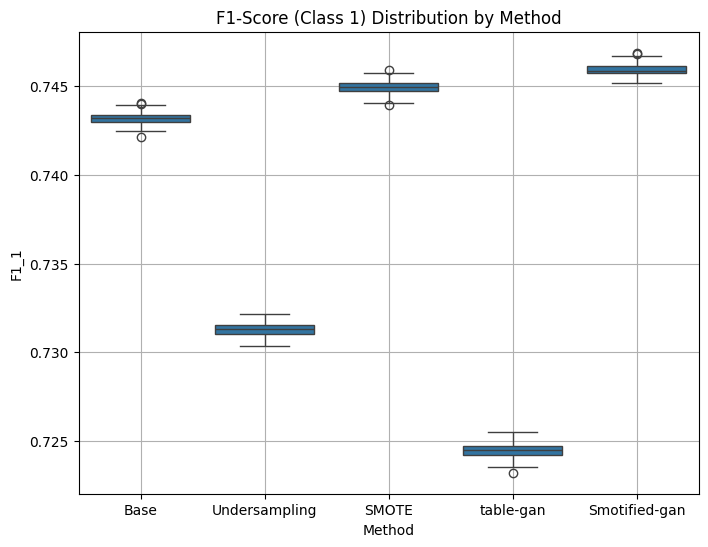

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
all_f1_df = pd.concat([
    pd.DataFrame({'Method': method, 'F1_1': [r['F1_1'] for r in results]})
    for method, results in all_results
])

sns.boxplot(data=all_f1_df, x='Method', y='F1_1')
plt.title('F1-Score (Class 1) Distribution by Method')
plt.grid(True)
plt.show()


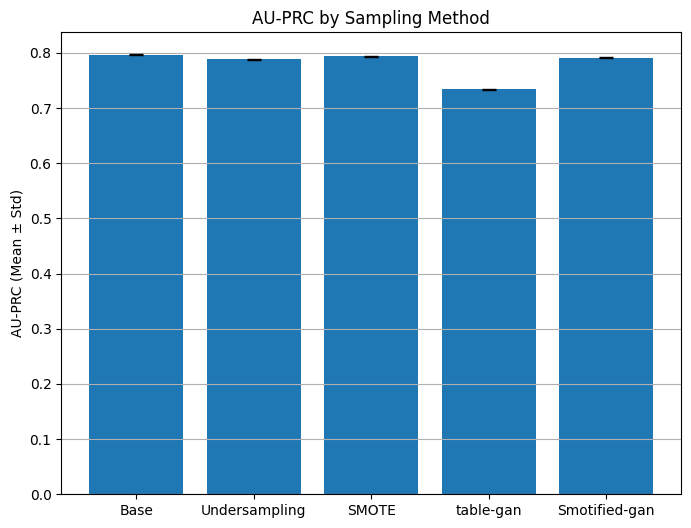

In [16]:
plt.figure(figsize=(8, 6))
x = stats_df['Method']
y = stats_df['AU_PRC_Mean']
err = stats_df['AU_PRC_Std']

plt.bar(x, y, yerr=err, capsize=5)
plt.ylabel('AU-PRC (Mean ± Std)')
plt.title('AU-PRC by Sampling Method')
plt.grid(axis='y')
plt.show()
